<a href="https://colab.research.google.com/github/ephalt/dog-breed-vision-classification/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multi-class Dog Breed Classification using Tensorflow and Tensorflow Hub.

## Problem

Identifying the breed of a dog given an image of a dog.

## Data

The data we are using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## Features

Some information about the data:
* We are dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
# unzip the uploaded data into Google Drive
# !unzip "/content/drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

# Get our workspace ready

In [4]:
import tensorflow as tf
print ("TF version:", tf.__version__)

TF version: 2.12.0


In [5]:
# Import necessary tools:

import tensorflow_hub as hub
print ("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (yes)" if tf.config.list_physical_devices("GPU") else "not available")

TF Hub version: 0.14.0
GPU available (yes)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our image intor Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [6]:
# Checkout the labels of our data

labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [7]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: >

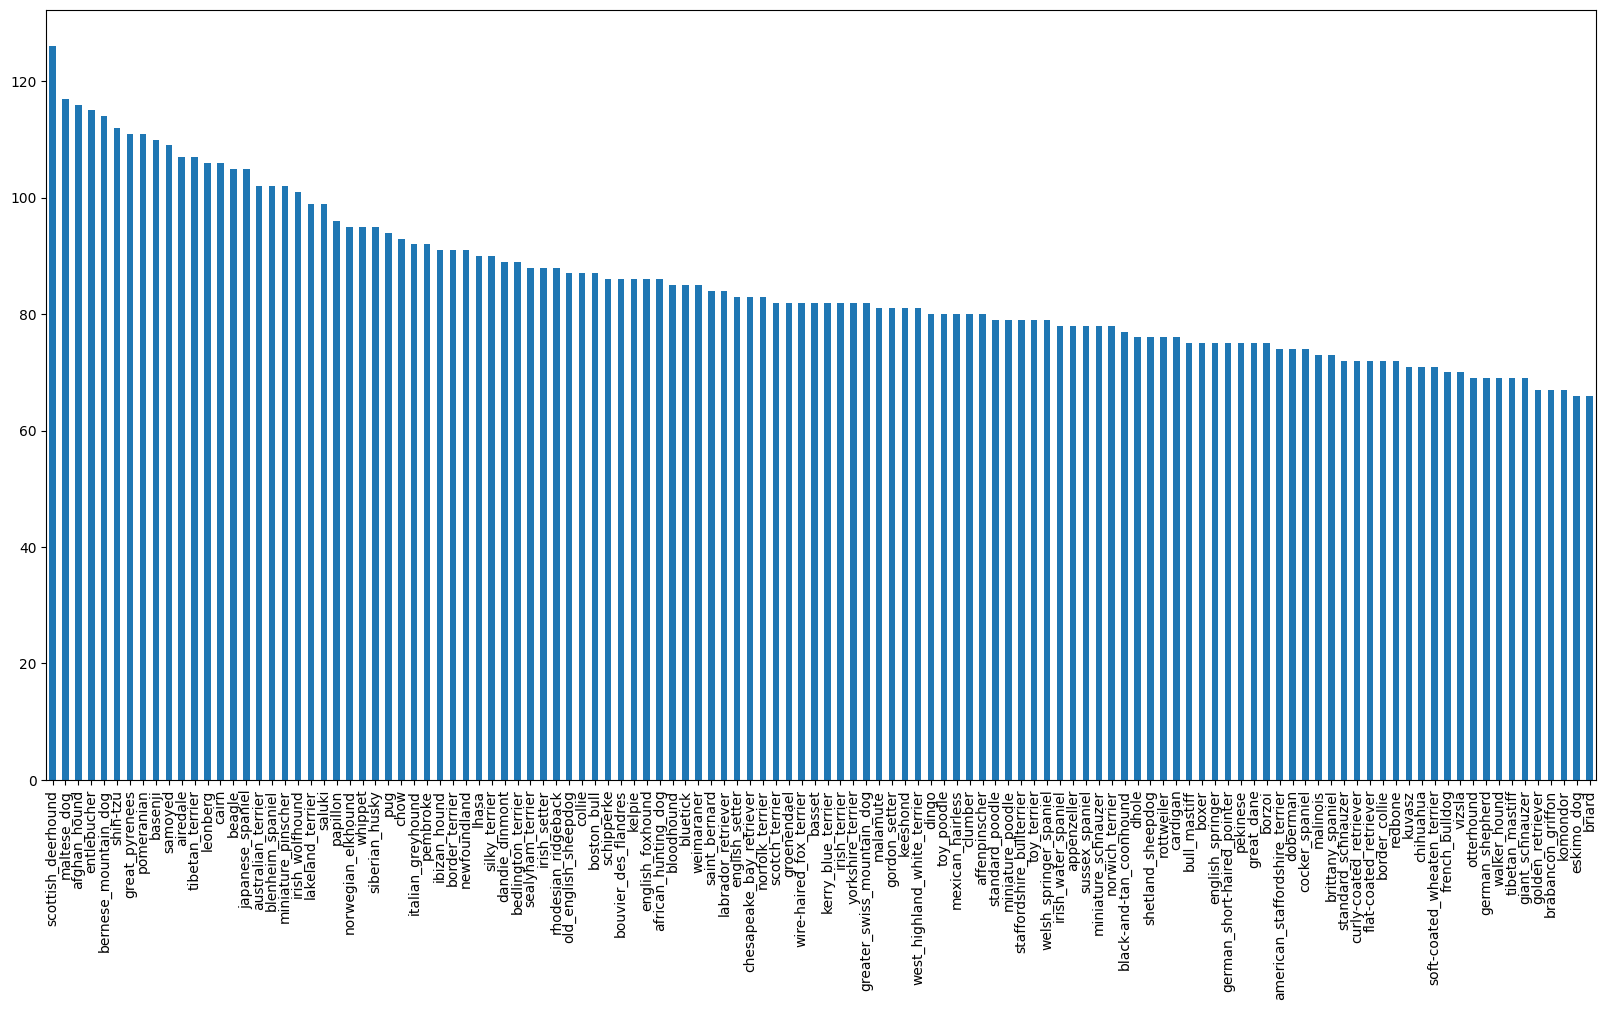

In [8]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [9]:
labels_csv["breed"].value_counts().median()

82.0

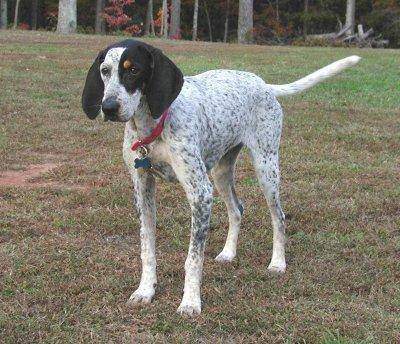

In [10]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames

In [11]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [12]:
# Create pathnames from image ID'S
filenames = ["drive/MyDrive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [13]:
import os
os.listdir("drive/MyDrive/Dog Vision/train/")[:10]

['e3a6203b61fa9cd2ffad92ebe31334ca.jpg',
 'dbb75e40f88b9703dbfe196f6ec57b3b.jpg',
 'ddc8d051c9b476c1eef9d35566490e59.jpg',
 'e8d09f74216aeede7e77829e177de7c0.jpg',
 'e63afe537a7d02e36846ca681e89f198.jpg',
 'e795a13bbfa8a72daeb315646f83068a.jpg',
 'e08af1f586d3150e4cecb3c42668b0e0.jpg',
 'db9f0d772b4b3b2452c7d6f92bb35f9c.jpg',
 'e0417404576aa3117ab1a0c646743ed9.jpg',
 'e4f5d391d0eab2c83493f2110a743da3.jpg']

In [14]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files! Proceed.")
else:
  print("Filenames do no match actual amount of files, check the target directory.")

Filenames match actual amount of files! Proceed.


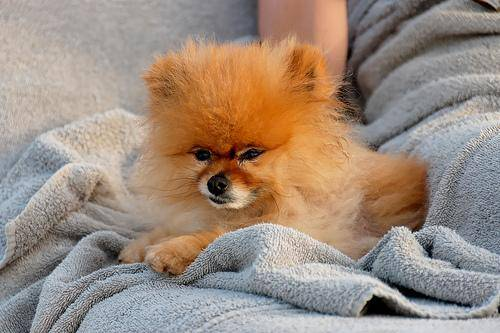

In [15]:
# One more check
Image(filenames[8000])

In [16]:
labels_csv["breed"][8000]

'pomeranian'

We have our training image file paths in a list, now we are going to prepare our labels.

In [17]:
labels = labels_csv["breed"].to_numpy()
#labels = np.array(labels) # does the same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [18]:
len(labels)

10222

In [19]:
# See if the number of labels matches the number of filenames
if len(labels) == len(filenames) :
  print("Number of labels matches number of filenames.")
else:
  print("Number of labels does not matches number of filenames, check data directories.")

Number of labels matches number of filenames.


In [20]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [21]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [22]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [23]:
len(boolean_labels)

10222

In [24]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there should be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [25]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [26]:
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set
Since the dataset from Kaggle doesn't come with validation set, we're going to create our own.

In [27]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [28]:
len(filenames)

10222

We are going to start of experimenting with ~1000 images and increase as needed

In [29]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 # @param {type:"slider", min:1000, max:10000, step:100}


In [30]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split


# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [31]:
# Let's check a part of the training data
X_train[:5], y_train[:2]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we are going to write a function which does a few things:

1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

In [32]:
# Convert image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [33]:
image.max(), image.min()

(255, 0)

In [34]:
# Turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

# Let's make a function to preprocess

In [35]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

# Creating data batches

What's a batch?

A batch (also called mini-batch) is a small portion of your data, say 32 (32 is generally the default batch size) images and their labels. In deep learning, instead of finding patterns in an entire dataset at the same time, you often find them one batch at a time.

Let's say you're dealing with 10,000+ images (which we are). Together, these files may take up more memory than your GPU has. Trying to compute on them all would result in an error.

Instead, it's more efficient to create smaller batches of your data and compute on one batch at a time.

TensorFlow is very efficient when your data is in batches of (image, label) Tensors. So we'll build a function to do create those first. We'll take advantage of of process_image function at the same time.

In [36]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

Now we've got a simple function to turn our image file path names and their associated labels into tuples (we can turn these into Tensors next), we'll create a function to make data batches.

Because we'll be dealing with 3 different sets of data (training, validation and test), we'll make sure the function can accomodate for each set.

We'll set a default batch size of 32 (it is advisable not to do it above 32).

In [37]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [38]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [39]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a bit hard to understand, let's visualiza them.

In [40]:
import matplotlib.pyplot as plt

# create a function for viewing images in a data batch

def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """

  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")



In [41]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [42]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

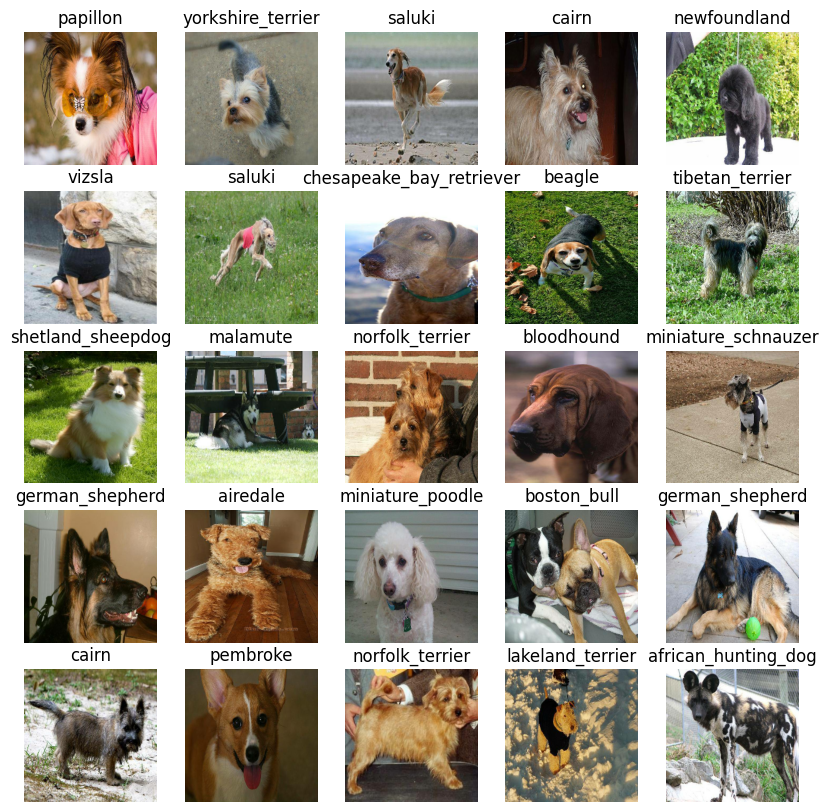

In [43]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

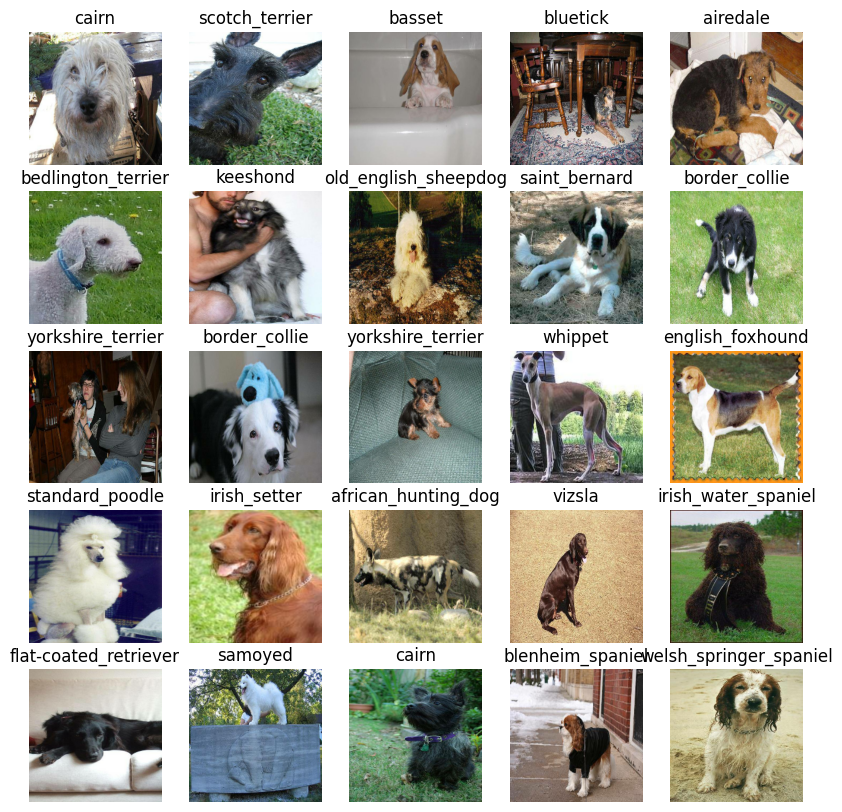

In [44]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model
Before we build a model, there are a few things we need to define:

* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [45]:
IMG_SIZE

224

In [46]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

We are going to put together our inputs, outputs, and model into a Keras deep learning model.

Let's create a function which:

* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Kera model in sequential fashion aka linear step by step process.
* Compiles the model (evaluated and improved).
* Builds the model.
* Returns the model.

In [47]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [48]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

TensorBoard Callback
To setup a TensorBoard callback, we need to do 3 things:

* Load the TensorBoard notebook extension ✅
* Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function. ✅
* Visualize our models training logs with the %tensorboard magic function (we'll do this after model training).
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard


In [49]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [50]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

## Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [51]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)
Our first model is only going to train on 1000 images, to make sure everything is working.

In [52]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [53]:
# Check to make sure we're still running on a GPU
print("GPU", "available (Yes)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (Yes)


## Let's create a function that trains a model.

* Create a model using create_model()
* Setup a TensorBoard callback using create_tensorboard_callback()
* Call the fit() function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use
* Return the model

In [54]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [56]:
# Fit the model to the data
model = train_model()

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting, to begin with, is a good thing! It means our model is learning.

## Checking the TensorBoard logs
The TensorBoard magic function (%tensorboard) will access the logs directory we created earlier and visualize its contents.

In [63]:
%tensorboard --logdir drive/MyDrive/Dog\ Vision/logs

## Making and evaluating predictions using a trained model

In [58]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [59]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 106s 2s/step


array([[0.00096459, 0.00239235, 0.0136285 , ..., 0.01621193, 0.00062542,
        0.01819039],
       [0.045687  , 0.0073106 , 0.01004468, ..., 0.00432483, 0.00258338,
        0.00134708],
       [0.00141475, 0.00015877, 0.00580316, ..., 0.02040996, 0.01114214,
        0.00218232],
       ...,
       [0.00451288, 0.00275927, 0.01336562, ..., 0.08319937, 0.00984116,
        0.00487168],
       [0.0013505 , 0.01142794, 0.00633239, ..., 0.01805528, 0.00074466,
        0.00989441],
       [0.00792409, 0.00130897, 0.00375583, ..., 0.00232306, 0.09141523,
        0.00872574]], dtype=float32)

In [60]:
predictions[0]

array([9.6459134e-04, 2.3923493e-03, 1.3628499e-02, 2.4660190e-03,
       5.5027837e-03, 3.7091330e-04, 9.9670386e-04, 6.6265245e-03,
       5.3481655e-03, 1.8608817e-03, 3.5627785e-03, 2.2876807e-03,
       2.0202074e-02, 6.6372793e-04, 1.5274485e-03, 3.8702833e-04,
       1.3381658e-03, 4.6553090e-03, 3.7048070e-03, 6.4314688e-03,
       1.0023469e-02, 2.8853405e-03, 1.0769053e-02, 2.7556514e-02,
       1.1523488e-03, 2.1136079e-03, 3.8359305e-03, 1.4955955e-04,
       7.8204041e-03, 1.0464877e-02, 4.5845885e-04, 3.0080203e-04,
       7.0184399e-03, 7.2163697e-03, 2.2479722e-02, 3.0598980e-03,
       2.1798972e-02, 1.1913885e-03, 8.4184185e-03, 3.1653442e-03,
       1.2321373e-03, 1.0409235e-02, 5.3579692e-04, 9.1862548e-03,
       4.4474071e-03, 2.3995892e-03, 1.0170781e-03, 3.4377184e-03,
       1.7271660e-02, 1.0328298e-03, 2.4820156e-03, 2.2065686e-02,
       2.4494175e-02, 3.3125451e-03, 2.3316001e-03, 2.1451199e-03,
       8.3756325e-04, 1.0767883e-03, 9.0207020e-03, 1.1331199e

In [61]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[0.01375542 0.0014501  0.00146672 0.00102447 0.0137143  0.00886311
 0.00420414 0.00599985 0.00445838 0.04426903 0.00216841 0.00410669
 0.00074095 0.0049213  0.0014846  0.02347072 0.0088458  0.03440351
 0.00437577 0.01492481 0.00171207 0.00025652 0.00101638 0.00467694
 0.00460366 0.00326915 0.0019128  0.00037923 0.00131827 0.00822033
 0.00708169 0.04465273 0.00309356 0.02127871 0.00093557 0.00118228
 0.00201584 0.02323495 0.00050046 0.00046763 0.00333443 0.07878087
 0.00393735 0.00069503 0.01350174 0.00818425 0.00363723 0.02248987
 0.0043031  0.0006496  0.01567592 0.01076    0.00425058 0.02444161
 0.00408512 0.0009746  0.00122162 0.00983392 0.00697575 0.01472379
 0.00191785 0.0005114  0.00385165 0.00447161 0.0013404  0.00245902
 0.00214609 0.01098211 0.00742303 0.01434852 0.00125481 0.00297053
 0.00637441 0.00162791 0.02588951 0.0032946  0.06400765 0.04891546
 0.00796263 0.00137234 0.01356071 0.00091885 0.005169   0.00549205
 0.00098504 0.00285671 0.00073577 0.0034671  0.0031413  0.0037

In [62]:
unique_breeds[113]

'walker_hound'

Having the the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [64]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dandie_dinmont'